In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# ==========================================
# 1. VISUAL BACKBONE (From Step 1 - Approved)
# ==========================================
class VisualBackbone(nn.Module):
    def __init__(self):
        super(VisualBackbone, self).__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V1
        resnet = models.resnet50(weights=weights)
        
        # Keep layers up to Layer 4 (output stride 32)
        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )
        
        # Freeze early layers
        for name, child in self.backbone.named_children():
            if name in ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']:
                for param in child.parameters():
                    param.requires_grad = False
            
    def forward(self, x):
        return self.backbone(x)







In [3]:
# ==========================================
# 2. ANNOTATION LOADER (Custom for your format)
# ==========================================
def load_and_process_annotations(file_path):
    """
    Reads the 10-column space-separated annotation file.
    Returns a DataFrame with calculated Centroids (cx, cy).
    """
    # Define column names based on your description
    col_names = [
        'track_id', 'xmin', 'ymin', 'xmax', 'ymax', 
        'frame', 'lost', 'occluded', 'generated', 'label'
    ]
    
    # Read space-separated file
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    
    # Calculate Centroids
    df['cx'] = (df['xmin'] + df['xmax']) / 2
    df['cy'] = (df['ymin'] + df['ymax']) / 2
    
    # Filter out lost/occluded if necessary (optional, currently keeping all)
    # df = df[df['lost'] == 0] 
    
    return df

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_9126/3017960053.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)


In [4]:
# ==========================================
# 3. CONTEXT EXTRACTOR (The Fusion Logic)
# ==========================================
def extract_features_for_agent(feature_map, agent_df, orig_w, orig_h):
    """
    Extracts visual features for a specific agent's trajectory.
    """
    # Get coordinates and normalize to [-1, 1]
    # Note: We use original image dimensions because the relative position 
    # of the agent (e.g., "center of image") is invariant to resizing.
    
    # cx / orig_w gives 0.0 to 1.0. 
    # Multiply by 2 -> 0.0 to 2.0. 
    # Subtract 1 -> -1.0 to 1.0.
    norm_x = 2 * (agent_df['cx'].values / orig_w) - 1
    norm_y = 2 * (agent_df['cy'].values / orig_h) - 1
    
    # Prepare grid for grid_sample: [1, Time, 1, 2]
    # We treat the trajectory as a "line of pixels" we want to sample
    grid = torch.tensor(np.stack([norm_x, norm_y], axis=1), dtype=torch.float32)
    grid = grid.unsqueeze(0).unsqueeze(2) 
    
    # Move to same device as feature map
    grid = grid.to(feature_map.device)
    
    # Sample
    # Feature map shape: [1, 2048, H_feat, W_feat]
    # Output shape: [1, 2048, Time, 1]
    sampled = F.grid_sample(feature_map, grid, align_corners=False)
    
    # Reshape to [Time, Channels] (Batch size 1 assumed for single scene)
    return sampled.squeeze(0).squeeze(-1).permute(1, 0)

Original Image Size: 1322 x 1079
Feature Map Shape: torch.Size([1, 2048, 16, 16])
Loaded 108886 annotation rows.
Extracting visual context for Agent ID: 13 (1032 frames)
Context Vector Shape: torch.Size([1032, 2048])


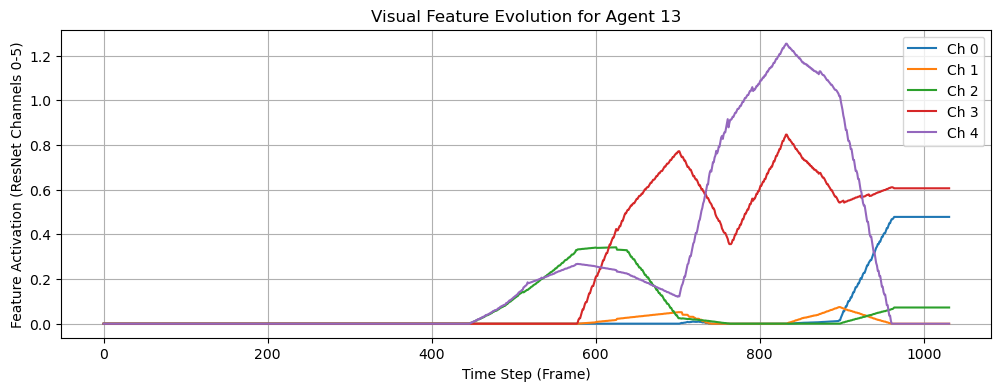

In [16]:
# ==========================================
# 4. MAIN EXECUTION PIPELINE
# ==========================================
if __name__ == "__main__":
    # --- A. CONFIGURATION ---
    img_path = '../datasets/SDD/archive/annotations/bookstore/video6/reference.jpg'       
    ann_path = '../datasets/SDD/archive/annotations/bookstore/video6/annotations.txt'     
    resize_dim = (512, 512)          # Standard input size for ResNet
    
    # --- B. LOAD IMAGE ---
    if not os.path.exists(img_path):
        print(f"Error: {img_path} not found. Please upload the image.")
        # Create a dummy image just so code doesn't crash during dry run
        orig_img = Image.new('RGB', (1920, 1080), color = 'gray')
    else:
        orig_img = Image.open(img_path).convert('RGB')
    
    orig_w, orig_h = orig_img.size
    print(f"Original Image Size: {orig_w} x {orig_h}")

    # Prepare input tensor
    transform = transforms.Compose([
        transforms.Resize(resize_dim),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(orig_img).unsqueeze(0) # [1, 3, 512, 512]

    # --- C. RUN VISUAL BACKBONE ---
    model = VisualBackbone()
    model.eval() # Eval mode for Batch Norm stability
    
    with torch.no_grad():
        feature_map = model(input_tensor)
    
    print(f"Feature Map Shape: {feature_map.shape}") # Should be [1, 2048, 16, 16]
    # save feature map for debugging
    torch.save(feature_map, 'feature_map.pt')
    # --- D. LOAD ANNOTATIONS ---
    if os.path.exists(ann_path):
        df = load_and_process_annotations(ann_path)
        print(f"Loaded {len(df)} annotation rows.")
        
        # --- E. EXTRACT & VISUALIZE FOR ONE AGENT ---
        # Pick the agent with the most frames to visualize a long path
        top_agent_id = df['track_id'].value_counts().idxmax()
        # fixed top_agent_id # comment the following line to get the actual top agent
        top_agent_id = 13

        agent_data = df[df['track_id'] == top_agent_id].sort_values('frame')
        
        print(f"Extracting visual context for Agent ID: {top_agent_id} ({len(agent_data)} frames)")
        
        # EXTRACT!
        context_features = extract_features_for_agent(feature_map, agent_data, orig_w, orig_h)
        print(f"Context Vector Shape: {context_features.shape}") # Should be [Time, 2048]
        
        # --- F. VERIFICATION PLOT ---
        # We plot the first 10 dimensions of the feature vector over time.
        # If the agent moves across different textures (road -> grass), these values should change.
        plt.figure(figsize=(12, 4))
        plt.plot(context_features[:, :5].numpy()) # Plot first 5 channels
        plt.title(f"Visual Feature Evolution for Agent {top_agent_id}")
        plt.xlabel("Time Step (Frame)")
        plt.ylabel("Feature Activation (ResNet Channels 0-5)")
        plt.legend([f"Ch {i}" for i in range(5)])
        plt.grid(True)
        plt.show()

    else:
        print("Annotations file not found.")

[ 513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.   513.   513.   513.   513.   513.   513.   513.
  513.   513.   513.

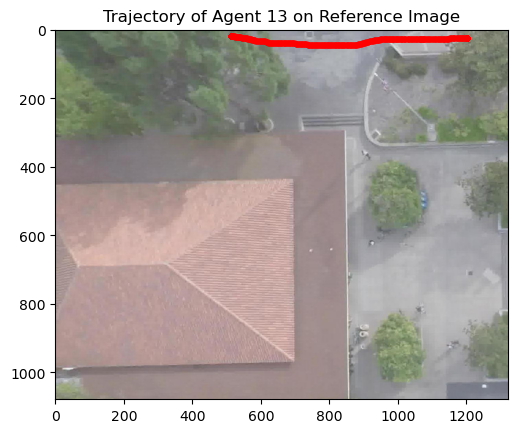

In [30]:
# let's plot agent 75 on reference image
x=agent_data['cx'].values
y=agent_data['cy'].values
print(x[1:900])
plt.imshow(orig_img)
plt.scatter(x, y, c='r', s=10)
plt.title(f"Trajectory of Agent {top_agent_id} on Reference Image")
plt.show()

Loaded Feature Map Shape: torch.Size([1, 2048, 16, 16])


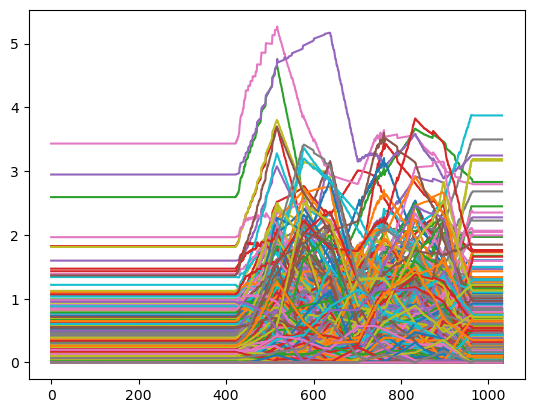

In [20]:
# Load saved feature map for debugging
feature_map = torch.load('feature_map.pt',weights_only=True)  
print(f"Loaded Feature Map Shape: {feature_map.shape}")
map=extract_features_for_agent(feature_map, agent_data, orig_w, orig_h)
plt.plot(map[:, :].numpy()) # Plot first 5 channels
plt.show()